In [54]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import layers
import PIL
from IPython import display
from tensorflow.keras.datasets import mnist
from tensorflow import GradientTape

In [55]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()

In [56]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [57]:
train_images=X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
print(train_images.shape)
train_images=(train_images-127.5)/127.5 #Normalise to -1 to +1

(60000, 28, 28, 1)


In [58]:
BUFFER_SIZE=60000
Batch_size=256

#Convert train_images to a tf.data.Dataset
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(Batch_size)

In [59]:
print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [60]:
def make_Genrator_Model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7,7,256)))
    
    assert model.output_shape==(None,7,7,256) #Debug
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape==(None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape==(None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape==(None,28,28,1)
    
    return model

In [61]:
generator=make_Genrator_Model()

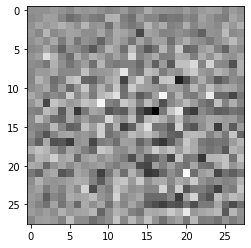

In [62]:
noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [63]:
def make_decriminator_model():
    model=tf.keras.Sequential()
    
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
          
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [64]:
discriminator=make_decriminator_model()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [65]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [66]:
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

In [67]:
def generator_loss(fake_output):
       return cross_entropy(tf.ones_like(fake_output),fake_output)

In [68]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [69]:
import os
checkpoint_dir='./training_checkpoints_Gan'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,
                              generator=generator,discriminator=discriminator)

In [70]:
EPOCHS=100
noise_dim=100
num_ex_to_generate=16
test_random_vectors=tf.random.normal([num_ex_to_generate,noise_dim])
print(test_random_vectors.shape)

(16, 100)


In [79]:
@tf.function
def train_step(images):
    noise=tf.random.normal([Batch_size,noise_dim])
    
    with GradientTape(persistent=True) as gen_tape,GradientTape(persistent=True) as disc_tape:
        genrated_images=generator(noise,training=True)
        
        real_output=discriminator(images,training=True)
        fake_output=discriminator(genrated_images,training=True)
        
        gen_loss=generator_loss(fake_output)
        disc_loss=discriminator_loss(real_output,fake_output)
        
    gradient_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradient_of_discriminator=gen_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradient_of_discriminator,discriminator.trainable_variables))

In [72]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start=time.time()

        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,test_random_vectors)
        
        if (epoch+1)%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,test_random_vectors)

In [81]:
def generate_and_save_images(model,epoch,test_input):
    predictions=model(test_input,training=False)
    fig=plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch{:04d}.png'.format(epoch))
    plt.show()

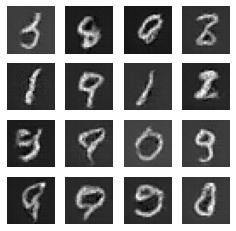

In [82]:
train(train_dataset,EPOCHS)